## <center> Packages & Connection </center>

In [2]:
import os
import h3 as h3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
from pyhive import presto
from keplergl import KeplerGl
from datetime import datetime, timedelta

import warnings
warnings.filterwarnings('ignore')

In [3]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 300)

## <center> Local extracted files </center>

In [4]:
notebook_path = os.getcwd()
notebook_path

'/Users/rapido/code-repository/pricing/non-peak-demand'

In [5]:
# FE level extract for chennai_link_20230710_to_20230723

raw_non_peak_demand_chennai_link = pd.read_csv('/Users/rapido/local-datasets/non-peak-demand/raw/raw_non_peak_demand_chennai_link_20230710_to_20230723.csv')
df_non_peak_demand_chennai_link = raw_non_peak_demand_chennai_link.copy(deep = True)
print(df_non_peak_demand_chennai_link.shape)

(6383431, 20)


In [6]:
df_non_peak_demand_chennai_link.head(2)

,yyyymmdd,week_start_date,weekday,week_day,quarter_hour,hour,city_name,service_name,service_detail_id,pickup_cluster,pickup_hex_8,drop_cluster,drop_hex_8,surge_strategy,fe_customer_id,fare_estimate_id,gross_customer_id,order_id,order_status,spd_fraud_flag
0,20230710,20230710,1 - Monday,Monday,1500,15,Chennai,Link,5bed473f1278885df4ea9d57,ECR Beach,88618c40c7fffff,Chennai Central,88618c4885fffff,surge_not_applied,6287c87bcf1a86085c0f29f3,64abd21e180a41bdfc801427,NaN,NaN,NaN,NaN
1,20230710,20230710,1 - Monday,Monday,1700,17,Chennai,Link,5bed473f1278885df4ea9d57,T Nagar,88618c4f23fffff,Chennai Central,88618c4885fffff,mismatch,5c8cc97b5e042733c9cc0c78,64abed8e817fa70715a186f7,NaN,NaN,NaN,NaN


## <center> Feature Engineering </center>

In [7]:
## Adding time_period column

def get_period(row):
    hour = int(row['hour'])
    if (hour >= 8 and hour <= 11):
        return "morning_peak"
    elif (hour >= 17 and hour <= 21):
        return "evening_peak"
    elif (hour > 11 and hour < 17):
        return "afternoon"
    else:
        return "rest"

df_non_peak_demand_chennai_link['time_period'] = df_non_peak_demand_chennai_link.apply(get_period, axis=1)

In [8]:
## Adding dropped column after spd_fraud check

def get_dropped_order(row):
    if (row['order_status'] == 'dropped') & (row['spd_fraud_flag'] != True ):
        return 1
    else:
        return 0
    
df_non_peak_demand_chennai_link['net_orders'] = df_non_peak_demand_chennai_link.apply(get_dropped_order, axis=1)

## Coverting to int (optional)
df_non_peak_demand_chennai_link['net_orders'] = df_non_peak_demand_chennai_link['net_orders'].astype('int')

## <center> Analysis with refined data </center>

In [9]:
## Final cleaned data

df_analysis = df_non_peak_demand_chennai_link.copy(deep = True)

### Level -> City | Service  

In [10]:
## Level -> City | Service 

df_analysis_city_level = df_analysis \
                            .groupby(['city_name', 'service_name']) \
                            .agg(
                                fe_count = pd.NamedAgg('fare_estimate_id', 'nunique'), 
                                gross_orders = pd.NamedAgg('order_id', 'nunique'), 
                                net_orders = pd.NamedAgg('net_orders', 'sum')
                                ) \
                            .reset_index()

## Adding funnel 
df_analysis_city_level['fe2rr'] = (df_analysis_city_level['gross_orders']*100.0/df_analysis_city_level['fe_count']).round(2)
df_analysis_city_level['g2n'] = (df_analysis_city_level['net_orders']*100.0/df_analysis_city_level['gross_orders']).round(2)
df_analysis_city_level['fe2net'] = (df_analysis_city_level['net_orders']*100.0/df_analysis_city_level['fe_count']).round(2)

## view
df_analysis_city_level.head()

,city_name,service_name,fe_count,gross_orders,net_orders,fe2rr,g2n,fe2net
0,Chennai,Link,6364485,1326624,824735,20.84,62.17,12.96


### Level -> City | Service | Time period 

In [11]:
## Level -> City | Service | Time period 

df_analysis_city_tp = df_analysis \
                            .groupby(['city_name', 'service_name', 'time_period']) \
                            .agg(
                                fe_count = pd.NamedAgg('fare_estimate_id', 'nunique'), 
                                gross_orders = pd.NamedAgg('order_id', 'nunique'), 
                                net_orders = pd.NamedAgg('net_orders', 'sum')
                                ) \
                            .reset_index()

## Adding funnel 
df_analysis_city_tp['fe_distribution'] = (df_analysis_city_tp['fe_count']*100.00/df_analysis_city_tp.fe_count.sum()).round(2)
df_analysis_city_tp['fe2rr'] = (df_analysis_city_tp['gross_orders']*100.0/df_analysis_city_tp['fe_count']).round(2)
df_analysis_city_tp['g2n'] = (df_analysis_city_tp['net_orders']*100.0/df_analysis_city_tp['gross_orders']).round(2)
df_analysis_city_tp['fe2net'] = (df_analysis_city_tp['net_orders']*100.0/df_analysis_city_tp['fe_count']).round(2)

## view
df_analysis_city_tp.head()

,city_name,service_name,time_period,fe_count,gross_orders,net_orders,fe_distribution,fe2rr,g2n,fe2net
0,Chennai,Link,afternoon,1647079,314680,204740,25.88,19.11,65.06,12.43
1,Chennai,Link,evening_peak,2106787,398572,269699,33.10,18.92,67.67,12.80
2,Chennai,Link,morning_peak,1610477,366292,211379,25.30,22.74,57.71,13.13
3,Chennai,Link,rest,1000142,247080,138917,15.71,24.70,56.22,13.89



        1. fe_distribution is similar b/w morning_peak & afternoon
        2. fe2rr drop in b/w morning_peak & afternoon
        3. morning good fe2rr but lower g2n (supply?)

### Level -> City | Weekday 

In [12]:
## Level -> City | Weekday 

df_analysis_city_wd = df_analysis \
                            .groupby(['city_name', 'weekday']) \
                            .agg(
                                fe_count = pd.NamedAgg('fare_estimate_id', 'nunique'), 
                                gross_orders = pd.NamedAgg('order_id', 'nunique'), 
                                net_orders = pd.NamedAgg('net_orders', 'sum')
                                ) \
                            .reset_index()

## Adding funnel 
df_analysis_city_wd['fe2rr'] = (df_analysis_city_wd['gross_orders']*100.0/df_analysis_city_wd['fe_count']).round(2)
df_analysis_city_wd['g2n'] = (df_analysis_city_wd['net_orders']*100.0/df_analysis_city_wd['gross_orders']).round(2)
df_analysis_city_wd['fe2net'] = (df_analysis_city_wd['net_orders']*100.0/df_analysis_city_wd['fe_count']).round(2)

## view
df_analysis_city_wd.sort_values('weekday')

,city_name,weekday,fe_count,gross_orders,net_orders,fe2rr,g2n,fe2net
0,Chennai,1 - Monday,1025158,230447,120799,22.48,52.42,11.78
1,Chennai,2 - Tuesday,824155,185820,121491,22.55,65.38,14.74
2,Chennai,3 - Wednesday,877304,193486,123870,22.05,64.02,14.12
3,Chennai,4 - Thursday,857995,194212,118601,22.64,61.07,13.82
4,Chennai,5 - Friday,912498,203157,129818,22.26,63.90,14.23
5,Chennai,6 - Saturday,1035068,181799,117919,17.56,64.86,11.39
6,Chennai,7 - Sunday,832307,137703,92237,16.54,66.98,11.08



            1. weekday vs weekend

### Level -> City | Weekday | Time period 

In [13]:
## Level -> City | Weekday | Time period 

df_analysis_city_wd_tp = df_analysis \
                            .groupby(['city_name', 'weekday', 'time_period']) \
                            .agg(
                                fe_count = pd.NamedAgg('fare_estimate_id', 'nunique'), 
                                gross_orders = pd.NamedAgg('order_id', 'nunique'), 
                                net_orders = pd.NamedAgg('net_orders', 'sum')
                                ) \
                            .reset_index()

## Work around for fe distribution
df_analysis_city_wd_tp = pd.merge \
                            (
                            df_analysis_city_wd_tp, \
                            df_analysis_city_wd[['city_name','weekday','fe_count']], \
                            how = 'left', \
                            left_on = ['city_name', 'weekday'], \
                            right_on = ['city_name', 'weekday'] \
                            )
df_analysis_city_wd_tp.rename(columns = {'fe_count_x' : 'fe_count', \
                                         'fe_count_y' : 'total_fe'}, \
                              inplace = True)

## Adding fe distribution & funnel
df_analysis_city_wd_tp['fe_distribution'] = (df_analysis_city_wd_tp['fe_count']*100.00/df_analysis_city_wd_tp['total_fe']).round(2) 
df_analysis_city_wd_tp['fe2rr'] = (df_analysis_city_wd_tp['gross_orders']*100.0/df_analysis_city_wd_tp['fe_count']).round(2)
df_analysis_city_wd_tp['g2n'] = (df_analysis_city_wd_tp['net_orders']*100.0/df_analysis_city_wd_tp['gross_orders']).round(2)
df_analysis_city_wd_tp['fe2net'] = (df_analysis_city_wd_tp['net_orders']*100.0/df_analysis_city_wd_tp['fe_count']).round(2)

df_analysis_city_wd_tp.head(2)

,city_name,weekday,time_period,fe_count,gross_orders,net_orders,total_fe,fe_distribution,fe2rr,g2n,fe2net
0,Chennai,1 - Monday,afternoon,242850,48331,29284,1025158,23.69,19.90,60.59,12.06
1,Chennai,1 - Monday,evening_peak,278858,57988,38897,1025158,27.20,20.79,67.08,13.95


In [14]:
df_analysis_city_wd_tp.sort_values(['time_period','weekday'])

,city_name,weekday,time_period,fe_count,gross_orders,net_orders,total_fe,fe_distribution,fe2rr,g2n,fe2net
0,Chennai,1 - Monday,afternoon,242850,48331,29284,1025158,23.69,19.90,60.59,12.06
4,Chennai,2 - Tuesday,afternoon,207129,43330,28979,824155,25.13,20.92,66.88,13.99
8,Chennai,3 - Wednesday,afternoon,223846,45315,30050,877304,25.52,20.24,66.31,13.42
12,Chennai,4 - Thursday,afternoon,213852,43700,29037,857995,24.92,20.43,66.45,13.58
16,Chennai,5 - Friday,afternoon,232584,48729,31205,912498,25.49,20.95,64.04,13.42
20,Chennai,6 - Saturday,afternoon,281488,49362,31602,1035068,27.20,17.54,64.02,11.23
24,Chennai,7 - Sunday,afternoon,245330,35913,24583,832307,29.48,14.64,68.45,10.02
1,Chennai,1 - Monday,evening_peak,278858,57988,38897,1025158,27.20,20.79,67.08,13.95
5,Chennai,2 - Tuesday,evening_peak,257719,56304,39312,824155,31.27,21.85,69.82,15.25
9,Chennai,3 - Wednesday,evening_peak,281184,58201,40586,877304,32.05,20.70,69.73,14.43


In [15]:
df_analysis_city_wd_tp.groupby(['time_period']).agg({'fe_distribution' : 'mean', 'g2n' : 'mean'})

,fe_distribution,g2n
time_period,,
afternoon,25.918571,65.248571
evening_peak,33.055714,67.644286
morning_peak,25.348571,60.431429
rest,15.672857,57.295714


In [16]:
pd.pivot_table( \
               df_analysis_city_wd_tp, 
               values= ['fe_distribution', 'fe_count', 'fe2rr', 'g2n'] , 
               index=['weekday'],
               columns=['time_period']
              )

fe2rr                                   fe_count  \
time_period   afternoon evening_peak morning_peak   rest afternoon   
weekday                                                              
1 - Monday        19.90        20.79        23.60  26.40    242850   
2 - Tuesday       20.92        21.85        23.07  25.66    207129   
3 - Wednesday     20.24        20.70        23.29  25.99    223846   
4 - Thursday      20.43        22.01        24.37  24.27    213852   
5 - Friday        20.95        20.48        24.28  25.37    232584   
6 - Saturday      17.54        14.06        21.15  22.56    281488   
7 - Sunday        14.64        15.12        16.82  22.56    245330   

                                                fe_distribution               \
time_period   evening_peak morning_peak    rest       afternoon evening_peak   
weekday                                                                        
1 - Monday          278858       313402  190048           23.69        27.20   
2 - Tuesday         257719       231853  127454           25.13        31.27   
3 - Wednesday       281184       251172  121102           25.52        32.05   
4 - Thursday        268394       242934  132815           24.92        31.28   
5 - Friday          318320       227599  133995           25.49        34.88   
6 - Saturday        410824       187461  155295           27.20        39.69   
7 - Sunday          291488       156056  139433           29.48        35.02   

                                        g2n                                   
time_period   morning_peak   rest afternoon evening_peak morning_peak   rest  
weekday                                                                       
1 - Monday           30.57  18.54     60.59        67.08        42.74  41.87  
2 - Tuesday          28.13  15.46     66.88        69.82        61.69  61.78  
3 - Wednesday        28.63  13.80     66.31        69.73        56.41  64.29  
4 - Thursday         28.31  15.48     66.45        69.79        53.51  51.68  
5 - Friday           24.94  14.68     64.04        67.57        60.04  62.94  
6 - Saturday         18.11  15.00     64.02        62.52        73.89  59.69  
7 - Sunday           18.75  16.75     68.45        67.00        74.74  58.82


               1. Friday, Saturday, Sunday (afternoon as peak)
               2. evening peak is steady for all days 
               3. afternoon fe % are also similar for all days 
               4. drop in morning peak 

# <center> Cluster - Time period Analysis </center>

### Level -> pickup_cluster

In [17]:
## Level -> pickup_cluster

df_analysis_pc = df_analysis \
                            .groupby(['pickup_cluster']) \
                            .agg(
                                fe_count = pd.NamedAgg('fare_estimate_id', 'nunique'), 
                                gross_orders = pd.NamedAgg('order_id', 'nunique'), 
                                net_orders = pd.NamedAgg('net_orders', 'sum')
                                ) \
                            .reset_index()

df_analysis_pc['fe2rr'] = (df_analysis_pc['gross_orders']*100.0/df_analysis_pc['fe_count']).round(2)
df_analysis_pc['g2n'] = (df_analysis_pc['net_orders']*100.0/df_analysis_pc['gross_orders']).round(2)
df_analysis_pc['fe2net'] = (df_analysis_pc['net_orders']*100.0/df_analysis_pc['fe_count']).round(2)

df_analysis_pc.head(2)

,pickup_cluster,fe_count,gross_orders,net_orders,fe2rr,g2n,fe2net
0,Adambakkam,44794,9321,5634,20.81,60.44,12.58
1,Adyar,71391,15224,9930,21.32,65.23,13.91


In [18]:
df_analysis_pc.describe()

,fe_count,gross_orders,net_orders,fe2rr,g2n,fe2net
count,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000
mean,39971.452830,8335.572327,5183.421384,20.066478,57.291509,11.696730
std,36782.108613,7828.828298,5175.086553,3.125560,11.084082,3.223397
min,516.000000,87.000000,12.000000,10.250000,13.790000,1.560000
25%,17535.500000,3693.000000,1930.500000,18.555000,55.060000,10.270000
50%,30492.000000,6066.000000,3692.000000,20.810000,59.880000,12.200000
75%,49088.500000,10776.000000,6769.500000,22.150000,63.630000,13.905000
max,214013.000000,45164.000000,30235.000000,27.130000,74.210000,17.690000


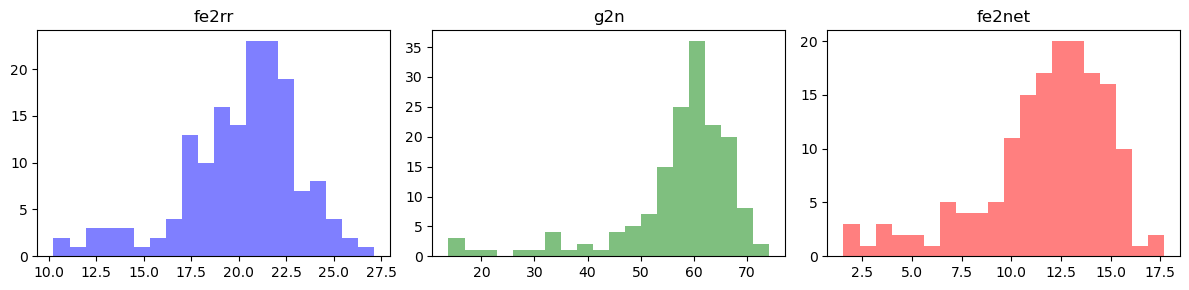

In [19]:
## Funnel

data1 = df_analysis_pc['fe2rr'] 
data2 = df_analysis_pc['g2n']  
data3 = df_analysis_pc['fe2net']  

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))  

# Plot histograms for each dataset on separate subplots
axes[0].hist(data1, bins=20, color='blue', alpha=0.5)
axes[0].set_title('fe2rr')

axes[1].hist(data2, bins=20, color='green', alpha=0.5)
axes[1].set_title('g2n')

axes[2].hist(data3, bins=20, color='red', alpha=0.5)
axes[2].set_title('fe2net')

# Adjust spacing between subplots
plt.tight_layout()

plt.show()

#

### Level -> Pickup_cluster | Time period 

In [20]:
## Level -> pickup_cluster | Time period 

df_analysis_pc_tp_all = df_analysis \
                                .groupby(['pickup_cluster', 'time_period']) \
                                .agg(
                                    fe_count = pd.NamedAgg('fare_estimate_id', 'nunique'), 
                                    gross_orders = pd.NamedAgg('order_id', 'nunique'), 
                                    net_orders = pd.NamedAgg('net_orders', 'sum')
                                    ) \
                                .reset_index()

## Work around for fe distribution
df_analysis_pc_tp_all = pd.merge \
                                (
                                df_analysis_pc_tp_all, \
                                df_analysis_pc[['pickup_cluster','fe_count']], \
                                how = 'left', \
                                left_on = ['pickup_cluster'], \
                                right_on = ['pickup_cluster'] \
                                )

df_analysis_pc_tp_all.rename(columns = {'fe_count_x' : 'fe_count', \
                                    'fe_count_y' : 'total_fe'}, \
                         inplace = True)

## Adding fe distribution & funnel
df_analysis_pc_tp_all['fe_distribution'] = (df_analysis_pc_tp_all['fe_count']*100.00/df_analysis_pc_tp_all['total_fe']).round(2) 
df_analysis_pc_tp_all['fe2rr'] = (df_analysis_pc_tp_all['gross_orders']*100.0/df_analysis_pc_tp_all['fe_count']).round(2)
df_analysis_pc_tp_all['g2n'] = (df_analysis_pc_tp_all['net_orders']*100.0/df_analysis_pc_tp_all['gross_orders']).round(2)
df_analysis_pc_tp_all['fe2net'] = (df_analysis_pc_tp_all['net_orders']*100.0/df_analysis_pc_tp_all['fe_count']).round(2)

In [21]:
df_analysis_pc_tp = df_analysis_pc_tp_all[df_analysis_pc_tp_all['time_period'] != 'rest']
df_analysis_pc_tp[df_analysis_pc_tp['pickup_cluster'].isin(['Adambakkam', 'Adyar'])]

,pickup_cluster,time_period,fe_count,gross_orders,net_orders,total_fe,fe_distribution,fe2rr,g2n,fe2net
0,Adambakkam,afternoon,10217,1964,1412,44794,22.81,19.22,71.89,13.82
1,Adambakkam,evening_peak,12575,2445,1829,44794,28.07,19.44,74.81,14.54
2,Adambakkam,morning_peak,16836,3568,1612,44794,37.59,21.19,45.18,9.57
4,Adyar,afternoon,19108,3615,2474,71391,26.77,18.92,68.44,12.95
5,Adyar,evening_peak,27858,5439,3480,71391,39.02,19.52,63.98,12.49
6,Adyar,morning_peak,15145,3730,2450,71391,21.21,24.63,65.68,16.18


In [22]:
df_analysis_pc_tp.describe()

,fe_count,gross_orders,net_orders,total_fe,fe_distribution,fe2rr,g2n,fe2net
count,477.000000,477.000000,477.000000,477.000000,477.000000,477.000000,477.000000,477.000000
mean,11229.800839,2261.039832,1436.748428,39971.452830,28.143291,19.609476,59.514151,11.777379
std,10943.791447,2190.618801,1464.841106,36704.753935,6.254176,3.846315,12.881134,3.399752
min,103.000000,11.000000,0.000000,516.000000,9.730000,7.480000,0.000000,0.000000
25%,4642.000000,901.000000,513.000000,17510.000000,24.460000,17.440000,51.440000,10.180000
50%,8211.000000,1646.000000,1007.000000,30492.000000,27.680000,19.490000,62.730000,12.100000
75%,14356.000000,2938.000000,1843.000000,49464.000000,31.130000,21.880000,69.000000,13.900000
max,86181.000000,14887.000000,9679.000000,214013.000000,61.470000,31.640000,80.970000,21.010000



            1. fe_count -> Right Skewed -> Median
            2. fe2rr -> symmetric -> mean
            3. g2n -> Left skewed -> Avg
            4. fe2net -> Almost symmetric -> mean/median

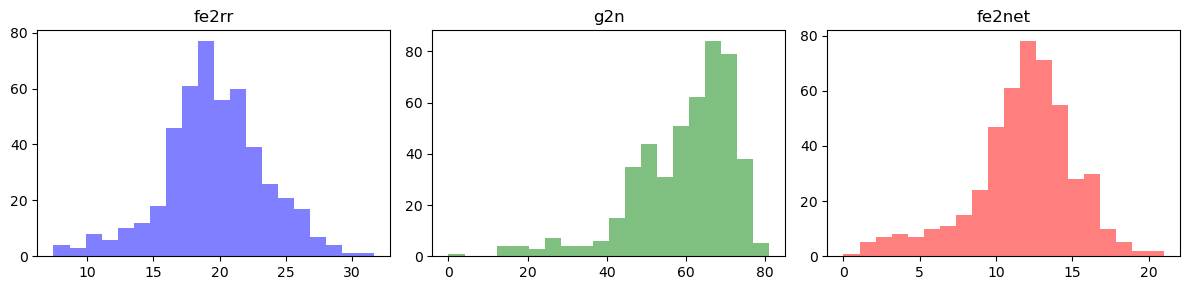

In [23]:
## Funnel Histogram

data1 = df_analysis_pc_tp['fe2rr']
data2 = df_analysis_pc_tp['g2n']  
data3 = df_analysis_pc_tp['fe2net']  

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))  

axes[0].hist(data1, bins=20, color='blue', alpha=0.5)
axes[0].set_title('fe2rr')
axes[1].hist(data2, bins=20, color='green', alpha=0.5)
axes[1].set_title('g2n')
axes[2].hist(data3, bins=20, color='red', alpha=0.5)
axes[2].set_title('fe2net')

# Adjust spacing between subplots
plt.tight_layout()

plt.show()

In [24]:
df_analysis_pc_tp.head()

,pickup_cluster,time_period,fe_count,gross_orders,net_orders,total_fe,fe_distribution,fe2rr,g2n,fe2net
0,Adambakkam,afternoon,10217,1964,1412,44794,22.81,19.22,71.89,13.82
1,Adambakkam,evening_peak,12575,2445,1829,44794,28.07,19.44,74.81,14.54
2,Adambakkam,morning_peak,16836,3568,1612,44794,37.59,21.19,45.18,9.57
4,Adyar,afternoon,19108,3615,2474,71391,26.77,18.92,68.44,12.95
5,Adyar,evening_peak,27858,5439,3480,71391,39.02,19.52,63.98,12.49


### Level ->Pickup_cluster | Time period | pivoted

In [25]:
df_analysis_pc_tp_pivoted =  pd.pivot_table( \
                                           df_analysis_pc_tp, 
                                           values= ['fe_distribution', 'fe_count', 'fe2rr', 'g2n'] , 
                                           index=['pickup_cluster'],
                                           columns=['time_period']
                                          )
df_analysis_pc_tp_pivoted

fe2rr                            \
time_period                        afternoon evening_peak morning_peak   
pickup_cluster                                                           
Adambakkam                             19.22        19.44        21.19   
Adyar                                  18.92        19.52        24.63   
Alamathi                               12.39        13.08        10.14   
Alandur                                21.50        22.01        23.79   
Allapakkam                             18.59        19.57        21.47   
Alwarpet                               20.85        21.19        26.71   
Alwarthirunagar                        18.00        18.11        20.98   
Ambattur                               19.05        20.47        21.65   
Ambattur Industrial Estate             21.62        23.31        24.48   
Ambattur OT                            20.68        21.46        24.62   
Anakaputhur                            18.36        16.96        21.13   
Anna Nagar                             19.49        19.16        22.73   
Anna Nagar East                        21.31        21.38        22.89   
Annanur                                15.86        16.42        17.44   
Arasankalani                           19.19        17.02        21.88   
Arumbakkam 2                           20.85        20.61        23.56   
Ashok Nagar Chennai                    19.83        21.83        23.63   
Avadi                                  17.37        16.56        17.74   
Ayanambakkam                           18.43        23.09        24.24   
Ayappakkam                             18.87        17.67        22.15   
Baby Nagar Velachery                   18.07        17.68        26.68   
Balaji Nagar                           18.88        21.16        21.99   
Basin Bridge                           16.79        16.33        18.72   
Beasant Avenue                         17.58         8.84        21.26   
Beasant Nagar                          19.94        16.65        24.75   
CHN CHETTINAD HEALTH CITY              28.78        16.97        21.39   
CHN GUDUVANCHERY                       21.14        19.27        21.63   
CHN KANDIGAI                           17.83        15.76        23.43   
CHN KELAMBAKKAM                        17.17        15.81        23.16   
CHN MAMBAKKAM                          21.02        16.05        19.13   
CHN MURUGAMANGALAM                     18.18        16.50        31.64   
CHN SRM UNIVERSITY                     25.00        23.01        25.88   
CHN URAPAKKAM                          20.79        20.36        21.34   
CHN VANDALUR                           14.40        16.28        18.45   
CMBT                                   24.37        23.01        25.00   
Chembarambakkam                        12.75        13.21        16.10   
Chennai Beach                          20.76        22.31        20.01   
Chennai Central                        16.96        17.52        17.21   
Chennai International Airport          17.49        17.64        17.60   
Chennai One IT park                    21.26        20.00        26.80   
Chepauk                                21.12        17.03        26.73   
Choolai                                21.90        21.38        26.30   
Chromepet                              19.34        20.29        21.51   
ECR Beach                              14.57        11.44        17.64   
East Tambaram                          18.49        21.72        20.76   
Egmore                                 19.97        19.25        22.97   
Egmore Metro                           21.13        22.45        23.07   
Ekkatutthangal Metro                   22.27        19.80        27.95   
Ennore                                 10.33         7.48         8.83   
Guindy                                 20.83        21.84        24.33   
Guindy 3                               19.66        18.90        28.39   
Guindy Madras Race Club                16.6

In [26]:
## Work around for removing MultiIndex columns
df_analysis_pc_tp_pivoted.columns = df_analysis_pc_tp_pivoted.columns.to_flat_index()
df_analysis_pc_tp_pivoted = df_analysis_pc_tp_pivoted.reset_index()
list_pivoted_new_columns = ['pickup_cluster', 'fe2rr_afternoon', 'fe2rr_evening_peak', 'fe2rr_morning_peak', 
                            'fe_afternoon', 'fe_evening_peak', 'fe_morning_peak', 'fe_distr_afternoon', 
                            'fe_distr_evening_peak', 'fe_distr_morning_peak', 'g2n_afternoon', 
                            'g2n_evening_peak', 'g2n_morning_peak']
df_analysis_pc_tp_pivoted.columns = list_pivoted_new_columns

df_analysis_pc_tp_pivoted.head(4)

,pickup_cluster,fe2rr_afternoon,fe2rr_evening_peak,fe2rr_morning_peak,fe_afternoon,fe_evening_peak,fe_morning_peak,fe_distr_afternoon,fe_distr_evening_peak,fe_distr_morning_peak,g2n_afternoon,g2n_evening_peak,g2n_morning_peak
0,Adambakkam,19.22,19.44,21.19,10217,12575,16836,22.81,28.07,37.59,71.89,74.81,45.18
1,Adyar,18.92,19.52,24.63,19108,27858,15145,26.77,39.02,21.21,68.44,63.98,65.68
2,Alamathi,12.39,13.08,10.14,339,390,207,30.49,35.07,18.62,21.43,15.69,28.57
3,Alandur,21.50,22.01,23.79,16898,23822,22183,20.04,28.26,26.31,74.24,74.08,53.79


In [27]:
df_analysis_pc_tp_cleared = df_analysis_pc_tp_pivoted.copy(deep = True)

In [28]:
## fe2rr_flag

df_analysis_pc_tp_cleared['fe2rr_flag'] = \
    np.where( 
            (
                (df_analysis_pc_tp_cleared['fe2rr_afternoon'] >= df_analysis_pc_tp_cleared['fe2rr_evening_peak'])
                 |
                (df_analysis_pc_tp_cleared['fe2rr_afternoon'] >= df_analysis_pc_tp_cleared['fe2rr_morning_peak'])
            ), 
            'High',
            'Low'
            )

df_analysis_pc_tp_cleared['fe_flag'] = \
    np.where( 
            (
                (df_analysis_pc_tp_cleared['fe_afternoon'] >= df_analysis_pc_tp_cleared['fe_evening_peak'])
                 |
                (df_analysis_pc_tp_cleared['fe_afternoon'] >= df_analysis_pc_tp_cleared['fe_morning_peak'])
            ), 
            'High',
            'Low'
            )

df_analysis_pc_tp_cleared['g2n_flag'] = \
    np.where( 
            (
                (df_analysis_pc_tp_cleared['g2n_afternoon'] >= df_analysis_pc_tp_cleared['g2n_evening_peak'])
                 |
                (df_analysis_pc_tp_cleared['g2n_afternoon'] >= df_analysis_pc_tp_cleared['g2n_morning_peak'])
            ), 
            'High',
            'Low'
            )

In [29]:
df_analysis_pc_tp_cleared[['pickup_cluster', 'fe_morning_peak', 'fe_afternoon', 'fe_evening_peak', 'fe_flag']].head()

,pickup_cluster,fe_morning_peak,fe_afternoon,fe_evening_peak,fe_flag
0,Adambakkam,16836,10217,12575,Low
1,Adyar,15145,19108,27858,High
2,Alamathi,207,339,390,High
3,Alandur,22183,16898,23822,Low
4,Allapakkam,12112,10086,11437,Low


In [30]:
df_analysis_pc_tp_cleared[['pickup_cluster', 'fe2rr_flag','fe_flag', 'g2n_flag']].head()

,pickup_cluster,fe2rr_flag,fe_flag,g2n_flag
0,Adambakkam,Low,Low,High
1,Adyar,Low,High,High
2,Alamathi,High,High,High
3,Alandur,Low,Low,High
4,Allapakkam,Low,Low,High


In [31]:
df_analysis_pc_tp_cleared.groupby(['fe2rr_flag']).agg({'pickup_cluster' : 'nunique'})

,pickup_cluster
fe2rr_flag,
High,93
Low,66


In [32]:
(93/df_analysis_pc_tp_cleared.pickup_cluster.nunique())*100

58.490566037735846

In [33]:
df_analysis_pc_tp_cleared.groupby(['fe_flag']).agg({'pickup_cluster' : 'nunique'})

,pickup_cluster
fe_flag,
High,83
Low,76


In [34]:
(83/df_analysis_pc_tp_cleared.pickup_cluster.nunique())*100

52.20125786163522

In [35]:
df_analysis_pc_tp_cleared.groupby(['g2n_flag']).agg({'pickup_cluster' : 'nunique'})

,pickup_cluster
g2n_flag,
High,110
Low,49


In [36]:
(110/df_analysis_pc_tp_cleared.pickup_cluster.nunique())*100

69.18238993710692

In [37]:
df_analysis_pc_tp_cleared.groupby(['fe2rr_flag', 'fe_flag', 'g2n_flag']).agg({'pickup_cluster' : 'nunique'})

pickup_cluster
fe2rr_flag fe_flag g2n_flag                
High       High    High                  27
                   Low                   27
           Low     High                  33
                   Low                    6
Low        High    High                  17
                   Low                   12
           Low     High                  33
                   Low                    4

In [38]:
((17+33)/df_analysis_pc_tp_cleared.pickup_cluster.nunique())*100

31.446540880503143

## Cluster level demand

In [39]:
df_analysis_pc_tp_pivoted.head()

,pickup_cluster,fe2rr_afternoon,fe2rr_evening_peak,fe2rr_morning_peak,fe_afternoon,fe_evening_peak,fe_morning_peak,fe_distr_afternoon,fe_distr_evening_peak,fe_distr_morning_peak,g2n_afternoon,g2n_evening_peak,g2n_morning_peak
0,Adambakkam,19.22,19.44,21.19,10217,12575,16836,22.81,28.07,37.59,71.89,74.81,45.18
1,Adyar,18.92,19.52,24.63,19108,27858,15145,26.77,39.02,21.21,68.44,63.98,65.68
2,Alamathi,12.39,13.08,10.14,339,390,207,30.49,35.07,18.62,21.43,15.69,28.57
3,Alandur,21.50,22.01,23.79,16898,23822,22183,20.04,28.26,26.31,74.24,74.08,53.79
4,Allapakkam,18.59,19.57,21.47,10086,11437,12112,25.91,29.38,31.12,64.85,67.02,49.52


### Level -> pickup_cluster | Time period 


In [40]:
## Afternoon | Hour 
## Cluster | Hour 

In [41]:
## Level -> pickup_cluster | Time period 

df_analysis_pc_hr_all = df_analysis \
                                .groupby(['pickup_cluster', 'hour', 'time_period']) \
                                .agg(
                                    fe_count = pd.NamedAgg('fare_estimate_id', 'nunique'), 
                                    gross_orders = pd.NamedAgg('order_id', 'nunique'), 
                                    net_orders = pd.NamedAgg('net_orders', 'sum')
                                    ) \
                                .reset_index()


## Adding fe distribution & funnel
df_analysis_pc_hr_all['fe2rr'] = (df_analysis_pc_hr_all['gross_orders']*100.0/df_analysis_pc_hr_all['fe_count']).round(2)
df_analysis_pc_hr_all['g2n'] = (df_analysis_pc_hr_all['net_orders']*100.0/df_analysis_pc_hr_all['gross_orders']).round(2)
df_analysis_pc_hr_all['fe2net'] = (df_analysis_pc_hr_all['net_orders']*100.0/df_analysis_pc_hr_all['fe_count']).round(2)

In [42]:
df_analysis_pc_hr = df_analysis_pc_hr_all[df_analysis_pc_hr_all['time_period'] != 'rest']
df_analysis_pc_hr[df_analysis_pc_hr['pickup_cluster'].isin(['Adambakkam', 'Adyar'])]

,pickup_cluster,hour,time_period,fe_count,gross_orders,net_orders,fe2rr,g2n,fe2net
8,Adambakkam,8,morning_peak,4571,1019,362,22.29,35.53,7.92
9,Adambakkam,9,morning_peak,5676,1266,436,22.30,34.44,7.68
10,Adambakkam,10,morning_peak,3797,773,467,20.36,60.41,12.30
11,Adambakkam,11,morning_peak,2792,510,347,18.27,68.04,12.43
12,Adambakkam,12,afternoon,2317,478,352,20.63,73.64,15.19
13,Adambakkam,13,afternoon,1772,351,250,19.81,71.23,14.11
14,Adambakkam,14,afternoon,2019,403,256,19.96,63.52,12.68
15,Adambakkam,15,afternoon,1810,325,236,17.96,72.62,13.04
16,Adambakkam,16,afternoon,2299,407,318,17.70,78.13,13.83
17,Adambakkam,17,evening_peak,2535,485,356,19.13,73.40,14.04


In [43]:
df_analysis_pc_hr.describe()

,hour,fe_count,gross_orders,net_orders,fe2rr,g2n,fe2net
count,2226.000000,2226.000000,2226.000000,2226.000000,2226.000000,2223.000000,2226.000000
mean,14.500000,2406.385894,484.508535,307.874663,19.449695,60.695619,11.884407
std,4.032035,2380.438441,486.481784,316.588383,4.474626,15.058185,3.872849
min,8.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.000000,939.250000,177.000000,107.000000,16.935000,54.280000,9.792500
50%,14.500000,1780.000000,347.000000,218.000000,19.435000,64.500000,12.175000
75%,18.000000,3006.250000,622.750000,395.000000,22.030000,71.090000,14.450000
max,21.000000,22213.000000,4047.000000,2320.000000,39.680000,100.000000,23.580000


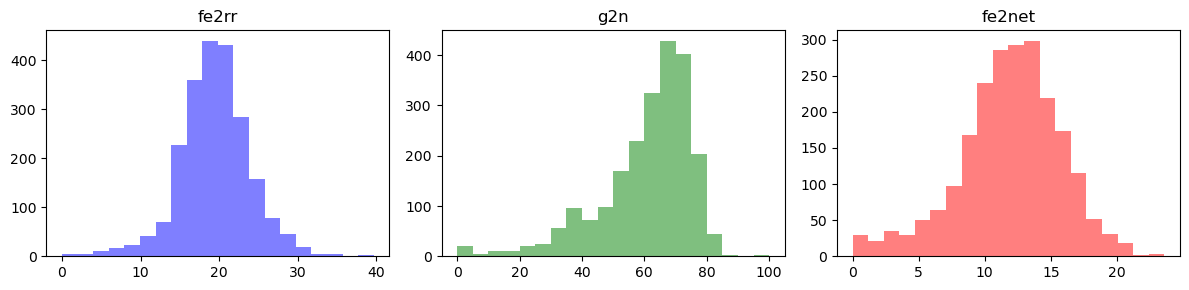

In [44]:
## Funnel Histogram

data1 = df_analysis_pc_hr['fe2rr']
data2 = df_analysis_pc_hr['g2n']  
data3 = df_analysis_pc_hr['fe2net']  

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))  

axes[0].hist(data1, bins=20, color='blue', alpha=0.5)
axes[0].set_title('fe2rr')
axes[1].hist(data2, bins=20, color='green', alpha=0.5)
axes[1].set_title('g2n')
axes[2].hist(data3, bins=20, color='red', alpha=0.5)
axes[2].set_title('fe2net')

# Adjust spacing between subplots
plt.tight_layout()

plt.show()

### Level ->Pickup_cluster | Hour | pivoted

In [45]:
df_analysis_pc_hr_pivoted =  pd.pivot_table( \
                                           df_analysis_pc_hr, 
                                           values= ['fe_count', 'fe2rr', 'g2n'] , 
                                           index=['pickup_cluster'],
                                           columns=['hour']
                                          )
df_analysis_pc_hr_pivoted

fe2rr                                     \
hour                                   8      9      10     11     12     13   
pickup_cluster                                                                 
Adambakkam                          22.29  22.30  20.36  18.27  20.63  19.81   
Adyar                               25.99  25.19  23.92  23.18  19.38  20.62   
Alamathi                             3.12  17.50  16.39   4.05  18.75   7.87   
Alandur                             23.88  24.82  23.20  22.76  21.58  22.69   
Allapakkam                          23.42  24.62  19.71  17.10  22.99  19.18   
Alwarpet                            29.40  28.49  25.33  24.15  20.95  23.18   
Alwarthirunagar                     25.33  22.69  17.86  17.36  21.46  18.27   
Ambattur                            23.13  23.20  21.02  17.75  19.39  19.57   
Ambattur Industrial Estate          24.81  28.55  21.85  21.59  22.18  23.30   
Ambattur OT                         26.12  25.21  24.36  22.03  22.20  18.84   
Anakaputhur                         23.28  22.94  18.25  18.30  19.64  21.01   
Anna Nagar                          23.71  22.06  23.59  21.65  20.17  21.30   
Anna Nagar East                     22.57  23.37  25.19  19.95  21.04  23.71   
Annanur                             17.82  18.32  17.46  15.63  18.62  17.73   
Arasankalani                        26.99  21.14  20.21  16.90  22.53  21.23   
Arumbakkam 2                        25.61  24.25  22.33  21.10  21.49  22.99   
Ashok Nagar Chennai                 24.46  25.31  22.11  21.71  21.58  18.65   
Avadi                               20.61  17.64  16.92  14.46  18.24  17.93   
Ayanambakkam                        26.44  26.17  24.83  17.88  21.50  22.51   
Ayappakkam                          22.98  23.16  22.72  18.88  21.57  22.57   
Baby Nagar Velachery                29.07  27.25  25.79  22.11  23.35  19.63   
Balaji Nagar                        21.46  21.66  22.76  22.20  21.00  23.34   
Basin Bridge                        18.93  20.66  19.39  15.58  17.34  20.06   
Beasant Avenue                      14.62  26.46  24.68  14.88  20.10  16.07   
Beasant Nagar                       25.00  25.53  24.21  23.79  21.68  19.92   
CHN CHETTINAD HEALTH CITY           30.16  15.38  21.43  15.79  13.21  39.02   
CHN GUDUVANCHERY                    25.39  22.93  20.65  17.39  21.54  23.74   
CHN KANDIGAI                        34.81  21.56  16.05  19.25  15.75  18.44   
CHN KELAMBAKKAM                     22.03  24.20  23.79  22.45  19.55  18.25   
CHN MAMBAKKAM                       18.68  21.99  20.04  15.70  21.66  18.54   
CHN MURUGAMANGALAM                  39.68   8.82  36.36  32.00  28.26  27.78   
CHN SRM UNIVERSITY                  25.21  30.74  21.88  25.08  29.84  22.76   
CHN URAPAKKAM                       21.48  23.12  20.46  20.08  21.56  18.85   
CHN VANDALUR                        20.02  16.47  18.13  18.90  14.50  15.11   
CMBT                                25.66  25.42  25.26  22.43  24.65  26.24   
Chembarambakkam                     22.42  14.32  12.69  13.75  13.72  15.11   
Chennai Beach                       25.64  22.20  17.55  18.02  20.24  23.54   
Chennai Central                     16.18  20.55  16.87  15.03  18.16  16.51   
Chennai International Airport       17.15  19.20  17.61  16.18  15.00  15.82   
Chennai One IT park                 28.63  26.95  26.65  23.74  24.03  21.37   
Chepauk                             25.59  29.96  26.76  22.89  21.06  24.28   
Choolai                             28.65  28.56  25.27  21.96  22.57  22.46   
Chromepet                           23.55  21.17  20.98  20.17  21.81  21.26   
ECR Beach                           18.50  17.01  19.60  15.23  20.98  14.42   
East Tambaram                       21.47  21.66  19.99  19.50  20.03  18.34   
Egmore                              24.74  23.21  22.68  21.43  19.64  22.30   
Egmore Metro                        22.39  25.29  23.14  20.79  19.50  22.29   
Ekkatutthangal Metro                

## Work around for removing MultiIndex columns
df_analysis_pc_hr_pivoted.columns = df_analysis_pc_hr_pivoted.columns.to_flat_index()
df_analysis_pc_hr_pivoted = df_analysis_pc_hr_pivoted.reset_index()
hr_list_pivoted_new_columns = ['pickup_cluster', 
                            'fe2rr_12', 'fe2rr_13', 'fe2rr_14', 'fe2rr_15', 'fe2rr_16', 
                            'fe_12', 'fe_13', 'fe_14', 'fe_15', 'fe_16', 
                            'g2n_12', 'g2n_13', 'g2n_14', 'g2n_15', 'g2n_16']
df_analysis_pc_hr_pivoted.columns = hr_list_pivoted_new_columns

df_analysis_pc_hr_pivoted.head(4)